In [1]:
dataset_path = "./dataset"

In [2]:
print(os.listdir(dataset_path))

NameError: name 'os' is not defined

In [4]:
%pip install scikit-learn seaborn

import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, models, layers, callbacks
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

Note: you may need to restart the kernel to use updated packages.


In [5]:
base_dir = dataset_path + '/images/new_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.6,
    height_shift_range = 0.1,
    shear_range = 0.15,
    zoom_range = 0.25,
    horizontal_flip = True,
    
)
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (100, 100),
    batch_size = 16,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size= 16,
    class_mode='binary',
    shuffle = False
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (100, 100),
    batch_size = 16,
    class_mode = 'binary',
    shuffle = False
)

Found 3290 images belonging to 2 classes.
Found 940 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


<Figure size 640x480 with 0 Axes>

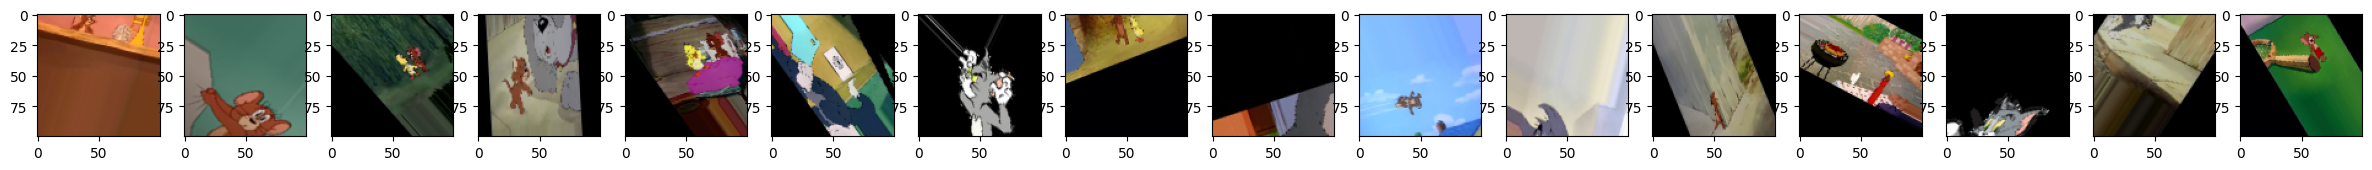

In [7]:
images, labels = train_generator[0]

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30,4))
for i in range(images.shape[0]):
    axarr[i].imshow(images[i])
plt.show()

Improved model - Semana 18

In [109]:
base_model_19 = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in base_model_19.layers:
    layer.trainable = False

for layer in base_model_19.layers[-4:]:
    layer.trainable = True

def get_model_19_compiled():

    model = models.Sequential([
        base_model_19,    
        layers.Flatten(),
        layers.Dense(512, name='dense_layer1'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        layers.Dense(128, name='dense_layer2'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(1, activation='sigmoid', name='output')
    ])

    model.compile(
        optimizer=optimizers.RMSprop(learning_rate=2e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

improved_model = get_model_19_compiled()
improved_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 3, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer1 (Dense)            │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer2 (Dense)            │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,452,545 (85.65 MB)

 Trainable params: 9,506,305 (36.26 MB)

 Non-trainable params: 12,946,240 (49.39 MB)

In [96]:
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, test_generator, class_0, class_1):
        super().__init__()
        self.model_ref = model
        self.test_generator = test_generator
        self.test_acc = []
        self.test_loss = []
        self.class_0 = class_0
        self.class_1 = class_1

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_generator, verbose=0)
        self.test_acc.append(acc)
        self.test_loss.append(loss)

In [ ]:
test_metrics_cb = TestMetricsCallback(improved_model, test_generator, 'Class 0', 'Class 1')

history_19 = improved_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                test_metrics_cb]
) 

Epoch 1/20


c:\Users\José Eduardo Díaz\Desktop\mini-proyectos\python\Image Classification\Saiyan_Classification_Model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 89s 426ms/step - accuracy: 0.6017 - loss: 0.6913 - val_accuracy: 0.7872 - val_loss: 0.4805
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 455ms/step - accuracy: 0.7328 - loss: 0.5316 - val_accuracy: 0.7915 - val_loss: 0.4557
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 456ms/step - accuracy: 0.7347 - loss: 0.5307 - val_accuracy: 0.8532 - val_loss: 0.3687
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 95s 462ms/step - accuracy: 0.7775 - loss: 0.4728 - val_accuracy: 0.8511 - val_loss: 0.3374
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 456ms/step - accuracy: 0.7755 - loss: 0.4625 - val_accuracy: 0.8702 - val_loss: 0.3260
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 457ms/step - accuracy: 0.7974 - loss: 0.4435 - val_accuracy: 0.8511 - val_loss: 0.3330
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 457ms/step - accuracy: 0.8071 - loss: 0.4183 - val_accuracy: 0.8638 - val_loss: 0.3144
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 94s 457ms/step - accuracy: 0.8197 - loss: 0.3967 - val

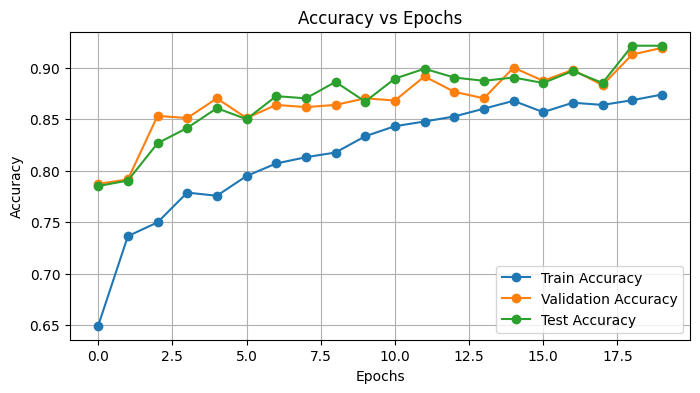

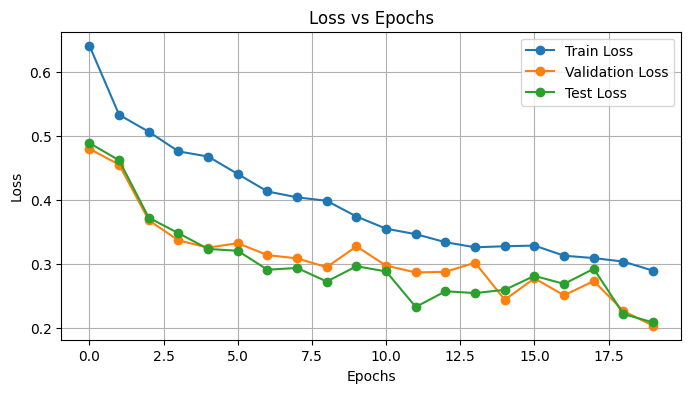

In [ ]:
epochs = range(len(test_metrics_cb.test_loss))

# Accuracy vs Epochs
plt.figure(figsize=(8, 4))
plt.plot(history_19.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_19.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(epochs, test_metrics_cb.test_acc, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Loss vs Epochs
plt.figure(figsize=(8, 4))
plt.plot(history_19.history['loss'], label='Train Loss', marker='o')
plt.plot(history_19.history['val_loss'], label='Validation Loss', marker='o')
plt.plot(epochs, test_metrics_cb.test_loss, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
improved_model.save('improved_model_semana18.h5')
improved_model = load_model('improved_model_semana18.h5')

59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.9389 - loss: 0.1745
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step


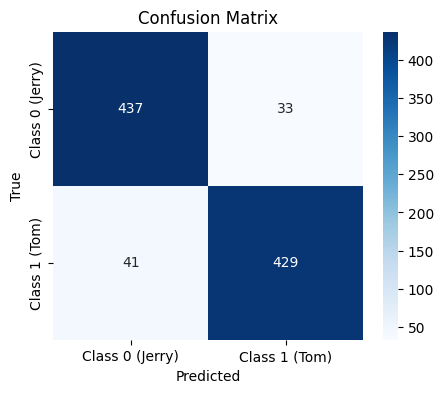

classification report
              precision    recall  f1-score   support

     Class 0       0.91      0.93      0.92       470
     Class 1       0.93      0.91      0.92       470

    accuracy                           0.92       940
   macro avg       0.92      0.92      0.92       940
weighted avg       0.92      0.92      0.92       940



In [133]:
test_generator.reset()
loss, acc = improved_model.evaluate(test_generator)

test_generator.reset()
y_pred = improved_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(test_generator.classes, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0 (Jerry)', 'Class 1 (Tom)'], 
            yticklabels=['Class 0 (Jerry)', 'Class 1 (Tom)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("classification report")
print(classification_report(test_generator.classes, y_pred_classes, target_names=['Class 0', 'Class 1']))

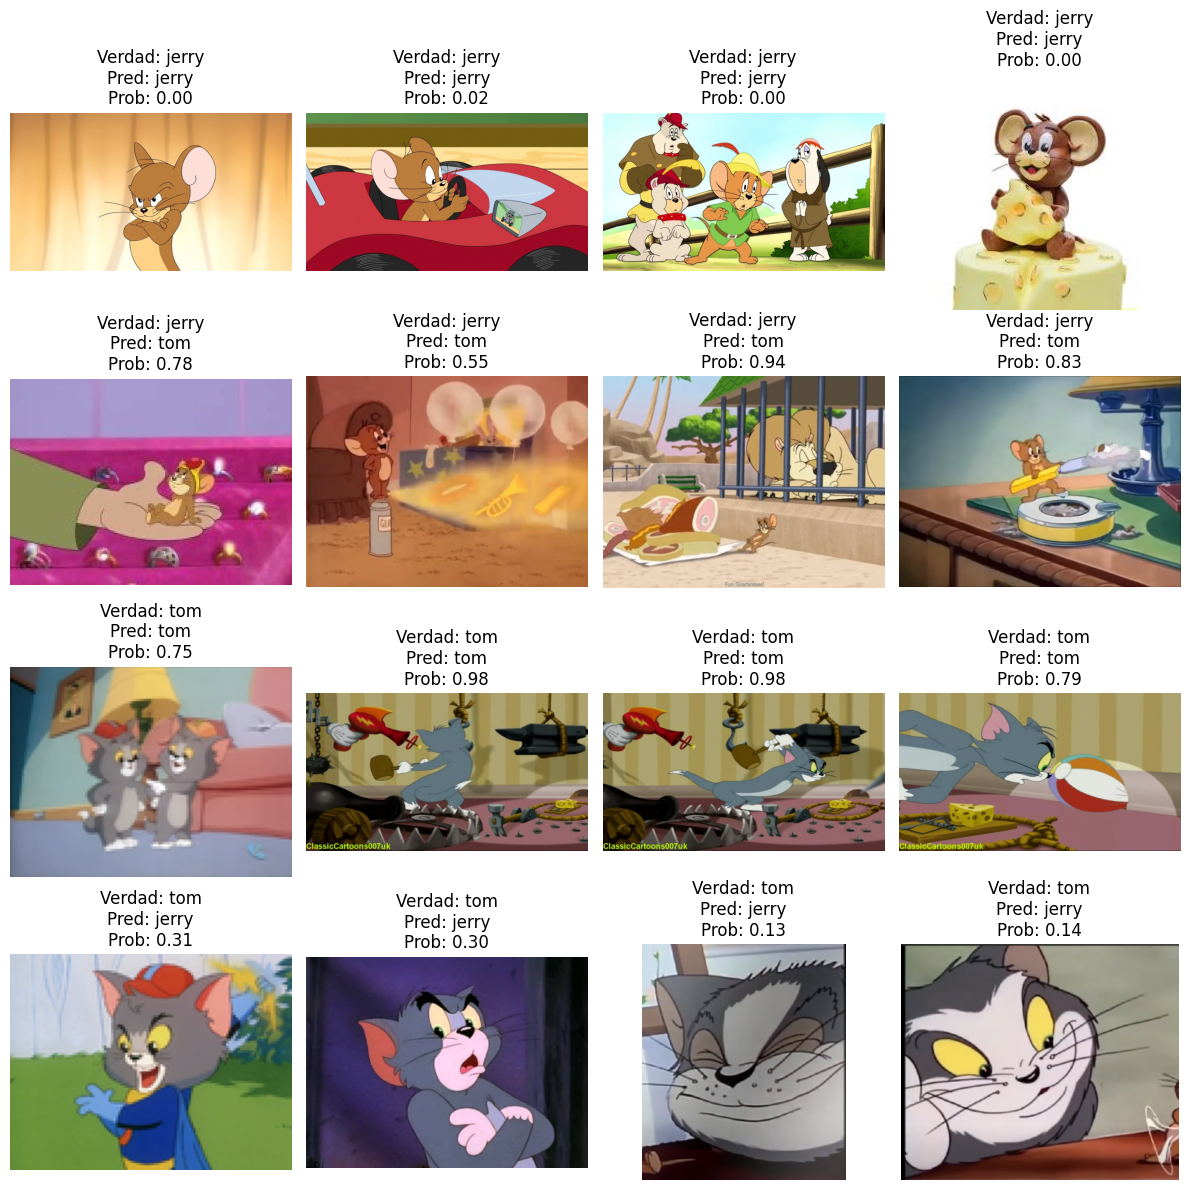

In [113]:
y_true = test_generator.classes
filepaths = test_generator.filepaths

class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

idx_tt = []  # Tom verdadero, Tom predicho (VP)
idx_tj = []  # Tom verdadero, Jerry predicho (FN)
idx_jj = []  # Jerry verdadero, Jerry predicho (VN)
idx_jt = []  # Jerry verdadero, Tom predicho (FP)

for i, (yt, yp) in enumerate(zip(y_true, y_pred_classes)):
    if yt == 0 and yp == 0:
        idx_tt.append(i)
    elif yt == 0 and yp == 1:
        idx_tj.append(i)
    elif yt == 1 and yp == 1:
        idx_jj.append(i)
    elif yt == 1 and yp == 0:
        idx_jt.append(i)

clase0 = idx_to_class[0]
clase1 = idx_to_class[1]

def show_examples(indices, true_label, pred_label, n=4):
    num_examples = min(n, len(indices))
    for i, idx in enumerate(indices[:num_examples]):
        img = plt.imread(filepaths[idx])
        prob = y_pred[idx][0]
        plt.subplot(4, 4, show_examples.counter)
        plt.imshow(img)
        plt.title(f"Verdad: {true_label}\nPred: {pred_label}\nProb: {prob:.2f}")
        plt.axis('off')
        show_examples.counter += 1

plt.figure(figsize=(12, 12))
show_examples.counter = 1
show_examples(idx_tt, clase0, clase0) # Tom/Tom
show_examples(idx_tj, clase0, clase1) # Tom/Jerry
show_examples(idx_jj, clase1, clase1) # Jerry/Jerry
show_examples(idx_jt, clase1, clase0) # Jerry/Tom
plt.tight_layout()
plt.show()

In [12]:
from tensorflow.keras.preprocessing import image

In [13]:
def interactive_prediction(model, img_path, target_size=(100, 100)):
    
    model = load_model(model)

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expand = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array_expand)[0][0]
    class_name = "Tom" if prediction > 0.5 else " Jerry"

    plt.imshow(img)
    plt.title(f"Predicted: {class_name} (Confidence: {prediction:.4f})")
    plt.axis('off')
    plt.show()

    return class_name

In [29]:
print(os.listdir('./dataset/images/interactive_test'))

['test1.jfif', 'test2.jfif', 'test3.jpg', 'test4.png', 'test5.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


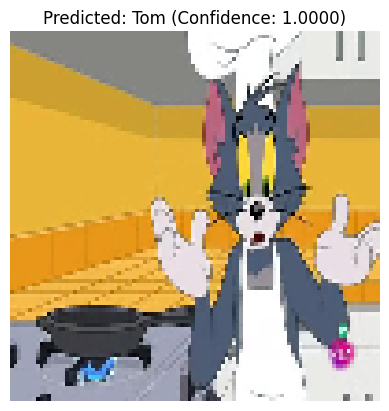

'Tom'

In [30]:
improved_model = load_model('improved_model_semana18.h5')

interactive_prediction('improved_model_semana18.h5', './dataset/images/interactive_test/test1.jfif')
